<a href="https://colab.research.google.com/github/rajatshah2006/AILMLCourseNoteBook/blob/main/NLPChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>
<center><font size=8>NLP Chatboat</center></font>

<br><br>


## **Problem Statement**

### DOMAIN:

Industrial safety. NLP based Chatbot.

### CONTEXT:
The database comes from one of the biggest industry in Brazil and in the world. It is an urgent need for industries/companies around the
globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.


### DATA DESCRIPTION:

This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an
occurrence of an accident.
Columns description:

*  Data: timestamp or time/date information
*  Countries: which country the accident occurred (anonymised)
*  Local: the city where the manufacturing plant is located (anonymised)
*  Industry sector: which sector the plant belongs to
*  Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
* Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors
involved in the accident)
* Genre: if the person is male of female
* Employee or Third Party: if the injured person is an employee or a third party
* Critical Risk: some description of the risk involved in the accident
* Description: Detailed description of how the accident happened.

### PROJECT OBJECTIVE:

Design a ML/DL based chatbot utility which can help the professionals to highlight the safety risk as per the incident
description.

## **Installing and Importing Necessary Libraries**

In [116]:
  # Connect Google Drive : Rajat

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [118]:
import zipfile as zf
import pandas as pd
import numpy as np
import datetime as dt
import re
import string
import spacy

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag
from collections import Counter
from gensim.models import Word2Vec

import unicodedata
from string import punctuation
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

In [119]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## **Loading the dataset**

In [120]:
data=pd.read_excel("/content/drive/MyDrive/AIMLCourse/CapstoneProject/DataSet_industrial_safety_and_health_database_with_accidents_description.xlsx")


In [121]:
data.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                425 non-null    int64         
 1   Data                      425 non-null    datetime64[ns]
 2   Countries                 425 non-null    object        
 3   Local                     425 non-null    object        
 4   Industry Sector           425 non-null    object        
 5   Accident Level            425 non-null    object        
 6   Potential Accident Level  425 non-null    object        
 7   Genre                     425 non-null    object        
 8   Employee or Third Party   425 non-null    object        
 9   Critical Risk             425 non-null    object        
 10  Description               425 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 36.7+ KB


**Observation:**
- There are 1 Unanmed column of int Type
- There are 9 object type column
- There is one datatime column

In [123]:
data.shape

(425, 11)

**Observation:**
- There are 425 rows and 11 columns

### Step 2: Data cleansing

##### Check for null values


In [124]:
data.isna().sum()

,0
Unnamed: 0,0
Data,0
Countries,0
Local,0
Industry Sector,0
Accident Level,0
Potential Accident Level,0
Genre,0
Employee or Third Party,0
Critical Risk,0


**Observation:**
- There are no null values

##### Check for duplicate values


In [125]:
# Check duplicate counts
duplicate_counts = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_counts}")

Number of duplicate rows: 0


**Observation:**
- There are no duplicate rows

In [126]:
# Renaming the columns appropriately
data.rename(columns={'Data':'Date', 'Countries':'Country', 'Local':'City', 'Genre':'Gender', 'Employee or Third Party':'Employee Type'}, inplace=True)

In [127]:
# Extracting year & month from 'Data' column
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day_name()

In [128]:
#  Remove Unnamed column

# Remove Unnamed column
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# # Remove Date column if it exists
# if 'Date' in data.columns:
#     data = data.drop('Date', axis=1)


In [129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      425 non-null    datetime64[ns]
 1   Country                   425 non-null    object        
 2   City                      425 non-null    object        
 3   Industry Sector           425 non-null    object        
 4   Accident Level            425 non-null    object        
 5   Potential Accident Level  425 non-null    object        
 6   Gender                    425 non-null    object        
 7   Employee Type             425 non-null    object        
 8   Critical Risk             425 non-null    object        
 9   Description               425 non-null    object        
 10  Year                      425 non-null    int32         
 11  Month                     425 non-null    int32         
 12  Day                   

In [130]:
data.head()

,Date,Country,City,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Month,Day
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,Friday
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,Saturday
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,Wednesday
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,Friday
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,Sunday


In [131]:
#Check for unique values in each column

for col in data.columns:
  print(f"Unique values in column '{col}': {data[col].unique()}")
  print(f"Number of unique values in column '{col}': {data[col].nunique()}")
  print("-" * 20)


Unique values in column 'Date': <DatetimeArray>
['2016-01-01 00:00:00', '2016-01-02 00:00:00', '2016-01-06 00:00:00',
 '2016-01-08 00:00:00', '2016-01-10 00:00:00', '2016-01-12 00:00:00',
 '2016-01-16 00:00:00', '2016-01-17 00:00:00', '2016-01-19 00:00:00',
 '2016-01-26 00:00:00',
 ...
 '2017-06-24 00:00:00', '2017-06-20 00:00:00', '2017-06-23 00:00:00',
 '2017-06-19 00:00:00', '2017-06-22 00:00:00', '2017-06-29 00:00:00',
 '2017-07-04 00:00:00', '2017-07-05 00:00:00', '2017-07-06 00:00:00',
 '2017-07-09 00:00:00']
Length: 287, dtype: datetime64[ns]
Number of unique values in column 'Date': 287
--------------------
Unique values in column 'Country': ['Country_01' 'Country_02' 'Country_03']
Number of unique values in column 'Country': 3
--------------------
Unique values in column 'City': ['Local_01' 'Local_02' 'Local_03' 'Local_04' 'Local_05' 'Local_06'
 'Local_07' 'Local_08' 'Local_10' 'Local_09' 'Local_11' 'Local_12']
Number of unique values in column 'City': 12
--------------------


**Observation:**
- There \n Not applicable values in critical rik column

In [132]:
data[data['Critical Risk']=='\nNot applicable'].head()

,Date,Country,City,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee Type,Critical Risk,Description,Year,Month,Day
154,2016-06-17,Country_02,Local_08,Metals,IV,V,Male,Employee,\nNot applicable,"At approximately 5:45 pm, the operator Paulo (...",2016,6,Friday


In [133]:
#  Replace \n Not applicable with Not applicable in critical Risk colunn

data['Critical Risk'] = data['Critical Risk'].replace('\nNot applicable', 'Not applicable')



In [134]:
#Check for unique values in each column

for col in data.columns:
  print(f"Unique values in column '{col}': {data[col].unique()}")
  print(f"Number of unique values in column '{col}': {data[col].nunique()}")
  print("-" * 20)

Unique values in column 'Date': <DatetimeArray>
['2016-01-01 00:00:00', '2016-01-02 00:00:00', '2016-01-06 00:00:00',
 '2016-01-08 00:00:00', '2016-01-10 00:00:00', '2016-01-12 00:00:00',
 '2016-01-16 00:00:00', '2016-01-17 00:00:00', '2016-01-19 00:00:00',
 '2016-01-26 00:00:00',
 ...
 '2017-06-24 00:00:00', '2017-06-20 00:00:00', '2017-06-23 00:00:00',
 '2017-06-19 00:00:00', '2017-06-22 00:00:00', '2017-06-29 00:00:00',
 '2017-07-04 00:00:00', '2017-07-05 00:00:00', '2017-07-06 00:00:00',
 '2017-07-09 00:00:00']
Length: 287, dtype: datetime64[ns]
Number of unique values in column 'Date': 287
--------------------
Unique values in column 'Country': ['Country_01' 'Country_02' 'Country_03']
Number of unique values in column 'Country': 3
--------------------
Unique values in column 'City': ['Local_01' 'Local_02' 'Local_03' 'Local_04' 'Local_05' 'Local_06'
 'Local_07' 'Local_08' 'Local_10' 'Local_09' 'Local_11' 'Local_12']
Number of unique values in column 'City': 12
--------------------


### Exploratory Data Analysis

#### Univariate Analysis

In [135]:
# function to plot a pie chart for a perticular column

def plot_pie_chart(df, column_name,chartname):
    """Plots a pie chart for the specified column in the dataframe.

    Args:
        df: The pandas DataFrame.
        column_name: The name of the column to plot.
    """

    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return

    value_counts = df[column_name].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(chartname)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


#### Distribution of Year Column

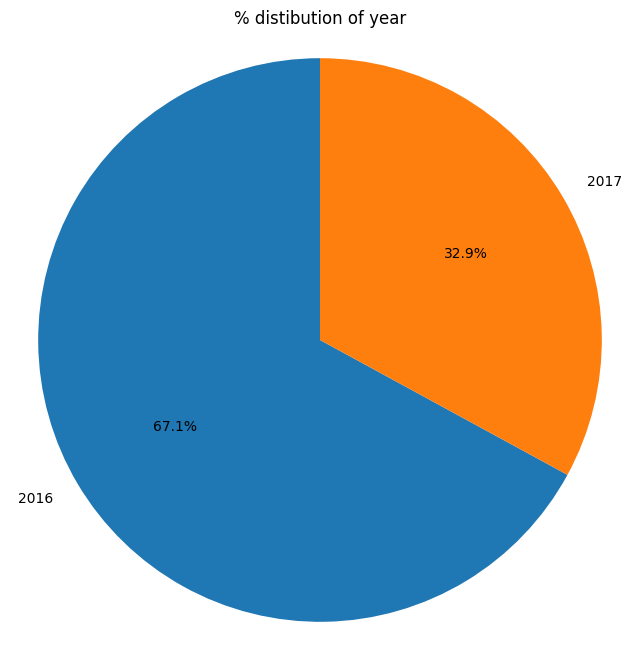

In [136]:
plot_pie_chart(data,'Year',"% distibution of year")

**Observation:**
-  Injuries seems to be higher in 2016 as compared to 2017

#### Distribution of Industry Sector  

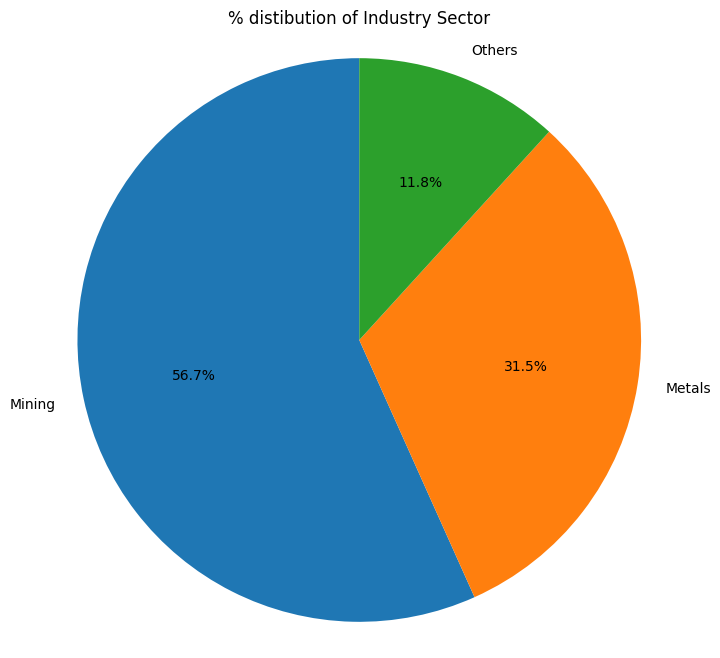

In [137]:
plot_pie_chart(data,'Industry Sector',"% distibution of Industry Sector")

**Observation:**
- Mining have most number of injuries followed by Metals and then we have other industries

#### Distribution of Country

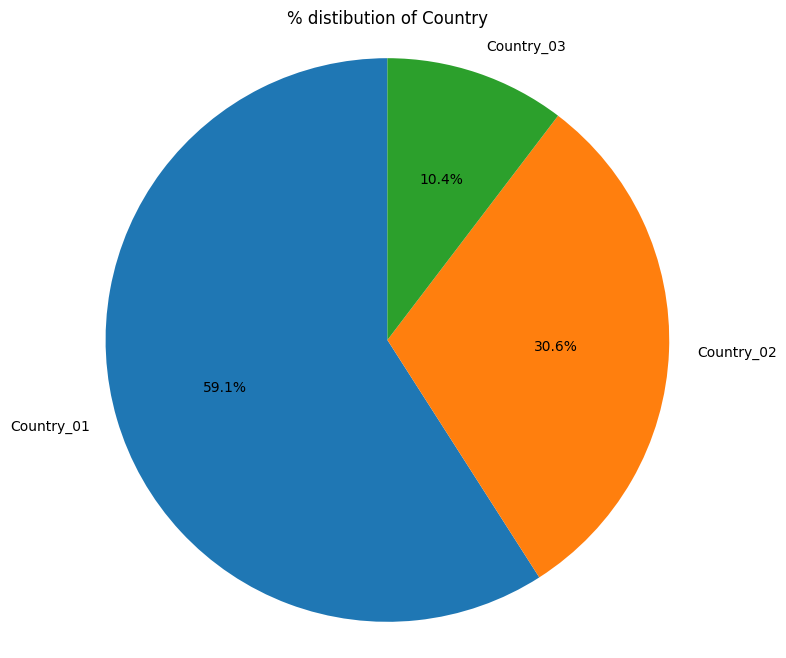

In [138]:
plot_pie_chart(data,'Country',"% distibution of Country")

**Observation:**
- Country_01 witnesses the highest number of accidents, followed by Country02, which together contribute to ~90% of the total accidents.

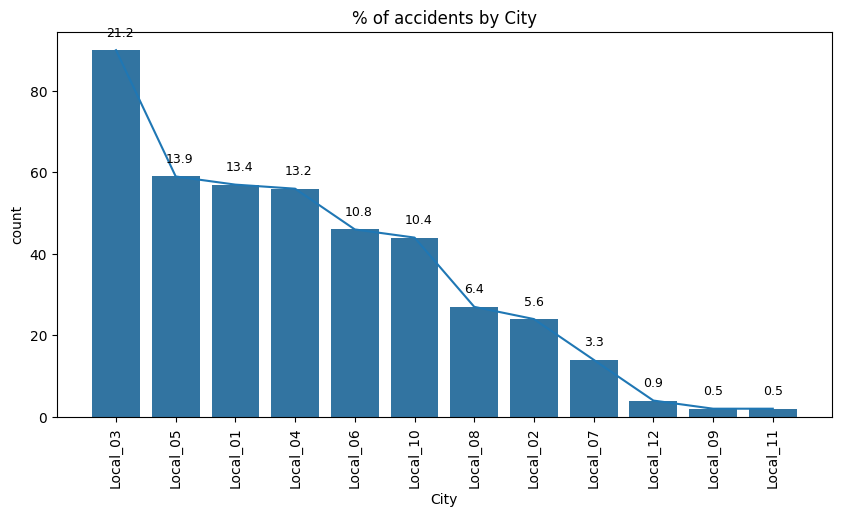

In [139]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data, x='City', order=data['City'].value_counts().index)
sns.lineplot(data['City'].value_counts().values)
plt.xticks(rotation=90)
total = sum(data['City'].value_counts())
for p in ax.patches:
    ax.annotate('{:.1f}'.format(100 * p.get_height() / total),
                (p.get_x(), p.get_height()), size=9, xytext=(10, 10), textcoords='offset points')
plt.title('% of accidents by City')
plt.show()


**Observation:**
- About 61% of the accidents together occur in plants located in Local_01, Local_03, Local_04 & Local_05 cities, of which Local_03 alone has recorded 21% accidents. Another 21% accidents are recorded by Local_06 & Local_10 cities. The bottom most 6 cities - Local_02, Local_07, Local_08, Local_09, Local_11, Local_12 cities witnessed only 17% of the accidents.

#### Distribution of Gender

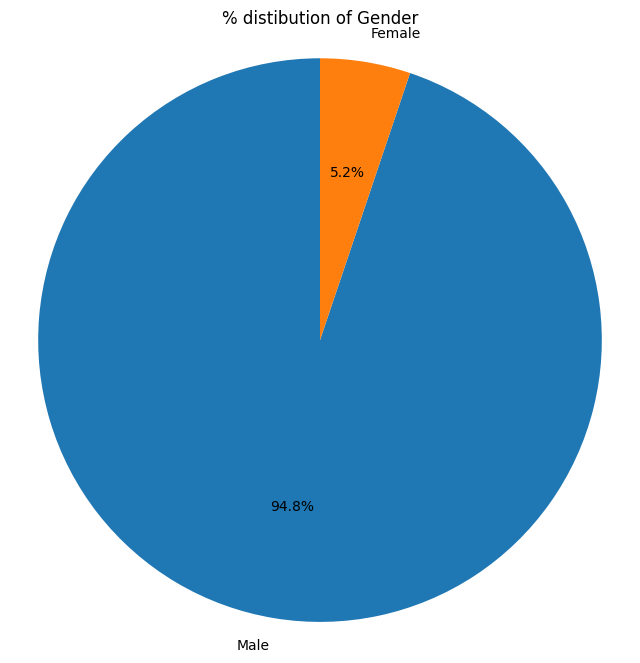

In [140]:
plot_pie_chart(data,'Gender',"% distibution of Gender")

**Observation:**
 - We can see the only ~5% Females have encountered accidents. This could be due to a general assumption of majority of industrial jobs being taken up by Males.

#### Distribution of Employee Type

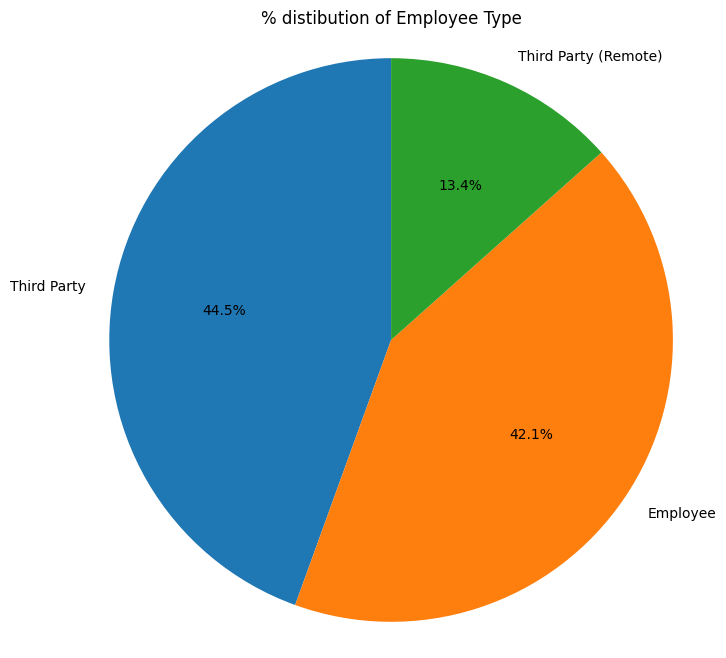

In [141]:
plot_pie_chart(data,'Employee Type',"% distibution of Employee Type")

**Observation:**
 - The minimum accidents are faced by the Third Party Remote workers as they are not always working on the sites. Overall 58% of the accidents are encountered Third Party employees.

Distribution of Critical Risk

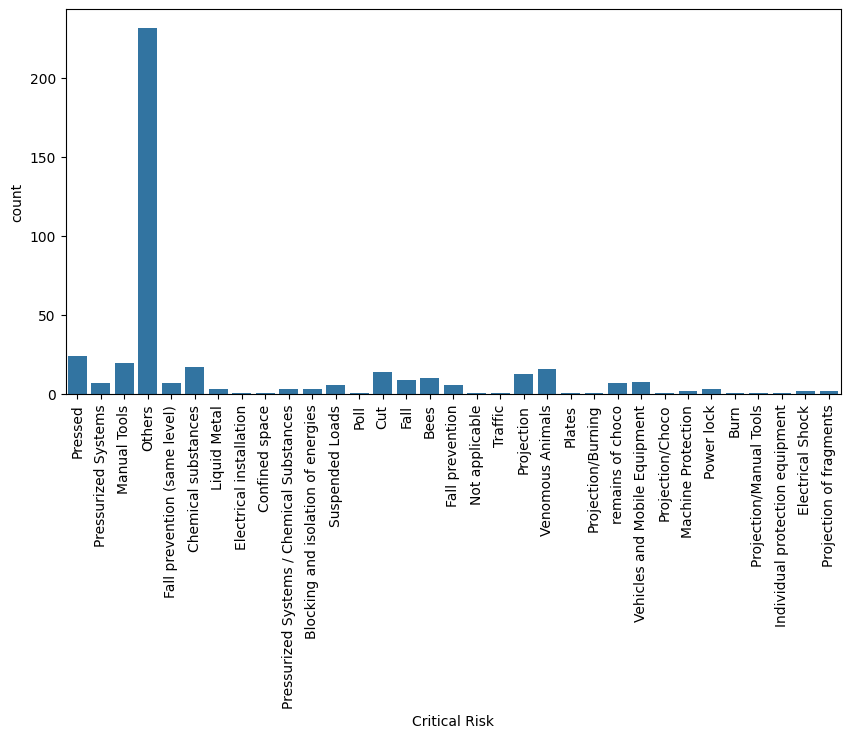

In [142]:
plt.figure(figsize=(10, 5))
sns.countplot(data, x='Critical Risk')
plt.xticks(rotation=90)
plt.show()

**Observation**
- Most of the Risk is Other which is 50% of data set
- The common risks are Pressed , Manual Tools , Chemical substances, Cut , Venomous Animals

##### DIstribution of Accident Level

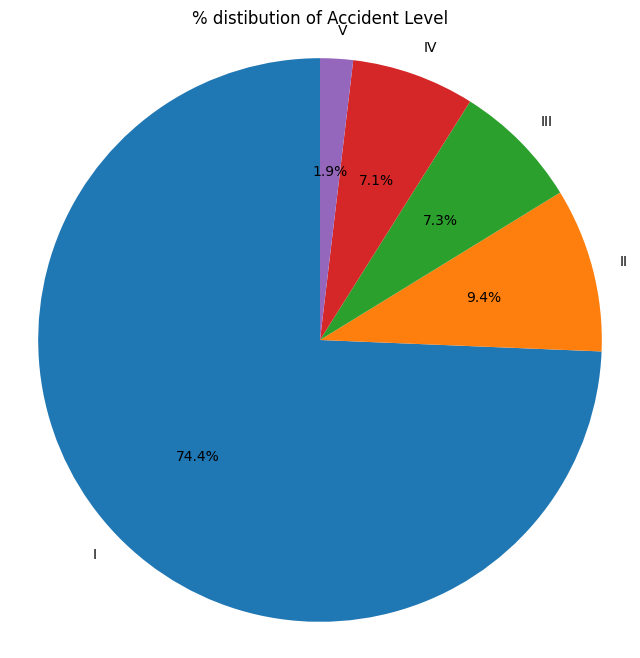

In [143]:
plot_pie_chart(data,'Accident Level',"% distibution of Accident Level")

**Observation:**
- Accident level I is most which means not severe
- Accident level I is followed by II, III, IV and V


#### Distribution of Potential Accident Level

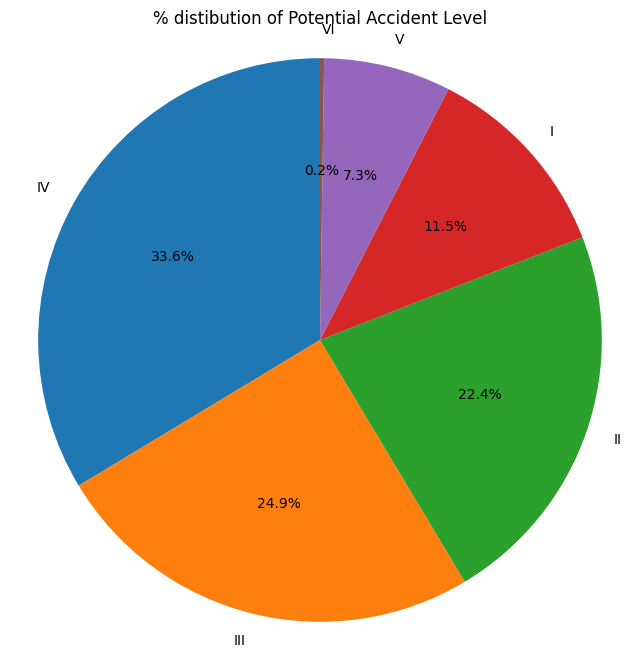

In [144]:
plot_pie_chart(data,'Potential Accident Level',"% distibution of Potential Accident Level")

**Observation:**
- Potential Accident Level: 81% accidents could potentially be moderately severe onces. and only 7.5% could've potentially been the most severe ones

- Potential Accident Level differs from the Accident Level. Majority are Level I accidents wheareas potential accidents have a majority in moderately severe ones (Level II, III & IV together).

#### Multivariate Analysis

#### Accident level vs Potential Accident level

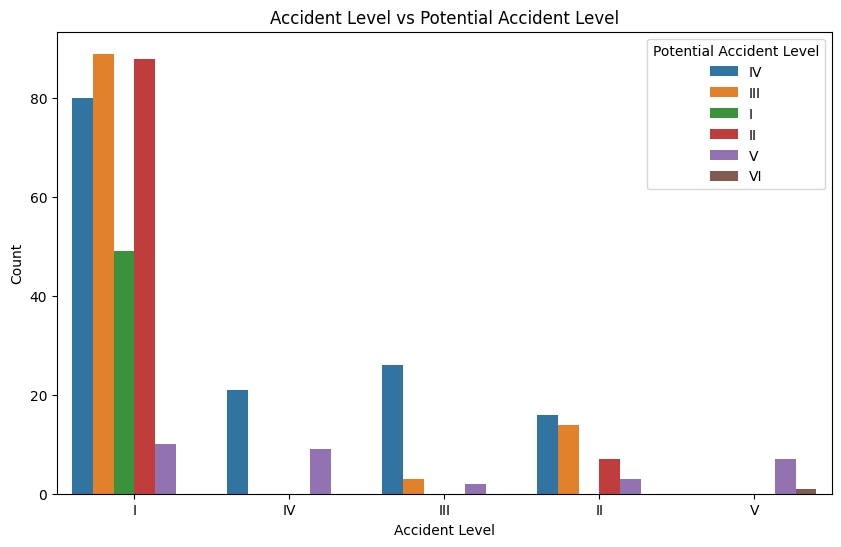

Correlation between Accident Level and Potential Accident Level: 0.50270414446615

Cross-tabulation of Accident Level vs Potential Accident Level:


Potential Accident Level,I,II,III,IV,V,VI
Accident Level,,,,,,
I,49,88,89,80,10,0
II,0,7,14,16,3,0
III,0,0,3,26,2,0
IV,0,0,0,21,9,0
V,0,0,0,0,7,1


In [145]:
# Accident level vs Potential Accident level

df=data.copy()
plt.figure(figsize=(10, 6))
sns.countplot(x='Accident Level', hue='Potential Accident Level', data=df)
plt.title('Accident Level vs Potential Accident Level')
plt.xlabel('Accident Level')
plt.ylabel('Count')
plt.show()

# Calculate the correlation between Accident Level and Potential Accident Level (if numerical representation is available)
# If 'Accident Level' and 'Potential Accident Level' are categorical, convert them to numerical for correlation
# Example using Label Encoding (you might need a different approach based on your data)
label_encoder = LabelEncoder()
df['Accident Level Encoded'] = label_encoder.fit_transform(data['Accident Level'])
df['Potential Accident Level Encoded'] = label_encoder.fit_transform(data['Potential Accident Level'])

correlation = df['Accident Level Encoded'].corr(df['Potential Accident Level Encoded'])
print(f"Correlation between Accident Level and Potential Accident Level: {correlation}")


# Create a cross-tabulation to see the frequency of each combination
cross_tab = pd.crosstab(df['Accident Level'], df['Potential Accident Level'])
print("\nCross-tabulation of Accident Level vs Potential Accident Level:")
cross_tab


**Observation:**
- There is 50% correlation between accideent level and Potential Accident Level

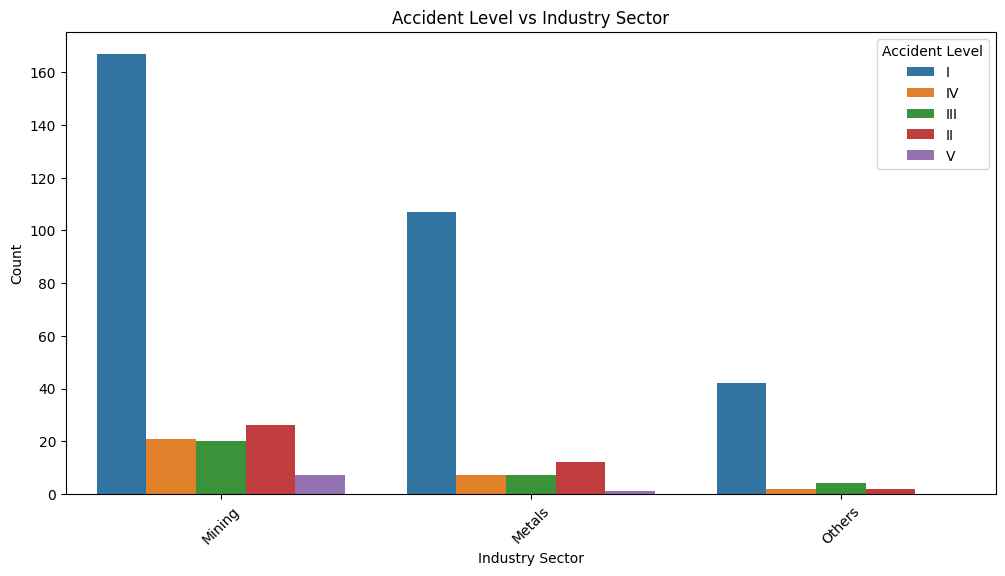

Accident Level,I,II,III,IV,V
Industry Sector,,,,,
Metals,107,12,7,7,1
Mining,167,26,20,21,7
Others,42,2,4,2,0


In [146]:
# industry vs Accident level

# Accident Level vs Industry Sector
plt.figure(figsize=(12, 6))
sns.countplot(x='Industry Sector', hue='Accident Level', data=data)
plt.title('Accident Level vs Industry Sector')
plt.xlabel('Industry Sector')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Calculate the correlation if numerical representation is available
# If categorical, consider using Cramer's V or Theil's U for association

# Industry vs Accident Level contingency table
industry_accident_level = pd.crosstab(data['Industry Sector'], data['Accident Level'])
industry_accident_level


**Observation:**
- Mining industry has most number of accidents and also similar proposition observed with accident level
- Metals and others have mostly level I accident
- Metails have more level II accidents while others have more III level followed by level I

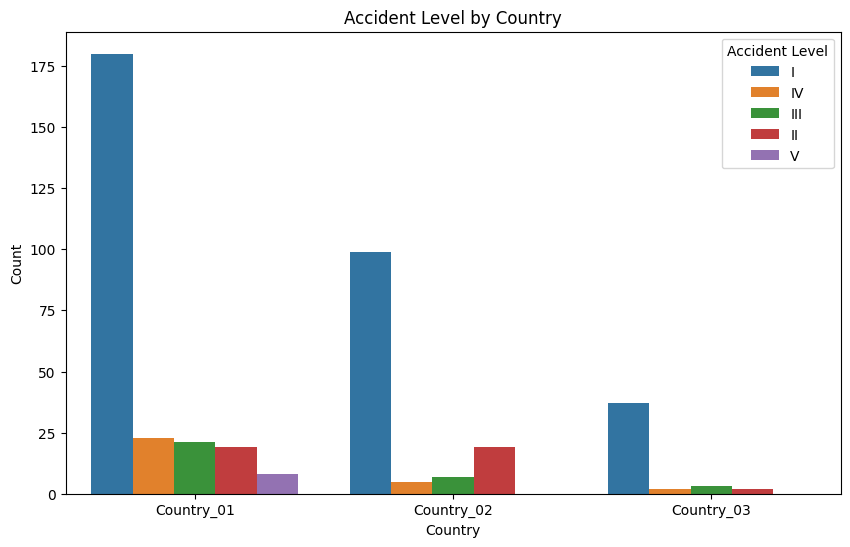

Accident Level         I        II       III        IV         V
Country                                                         
Country_01      0.717131  0.075697  0.083665  0.091633  0.031873
Country_02      0.761538  0.146154  0.053846  0.038462       NaN
Country_03      0.840909  0.045455  0.068182  0.045455       NaN


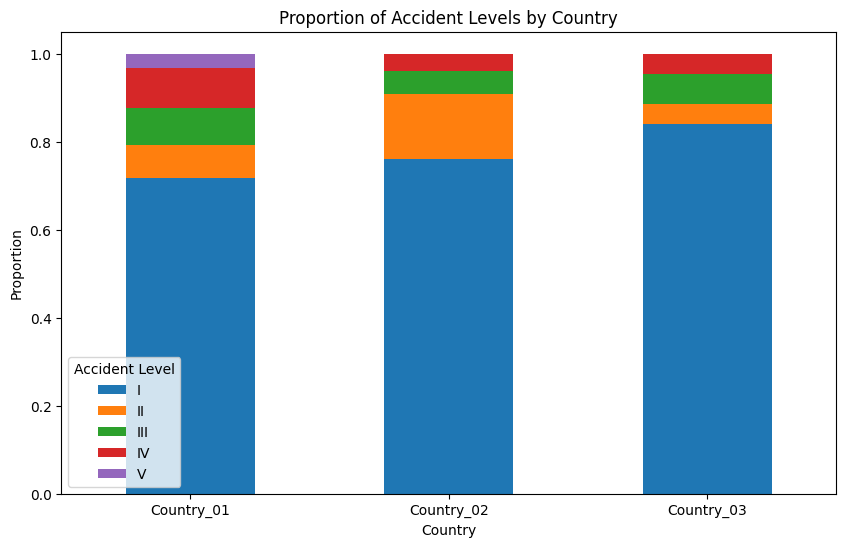

In [147]:
# Accident level by COuntry

# Accident level by country
plt.figure(figsize=(10, 6))
sns.countplot(x='Country', hue='Accident Level', data=data)
plt.title('Accident Level by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

# Calculate accident level proportions for each country
accident_level_by_country = data.groupby('Country')['Accident Level'].value_counts(normalize=True).unstack()
print(accident_level_by_country)

# Optional: Visualize the proportions
accident_level_by_country.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proportion of Accident Levels by Country')
plt.xlabel('Country')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Accident Level')
plt.show()


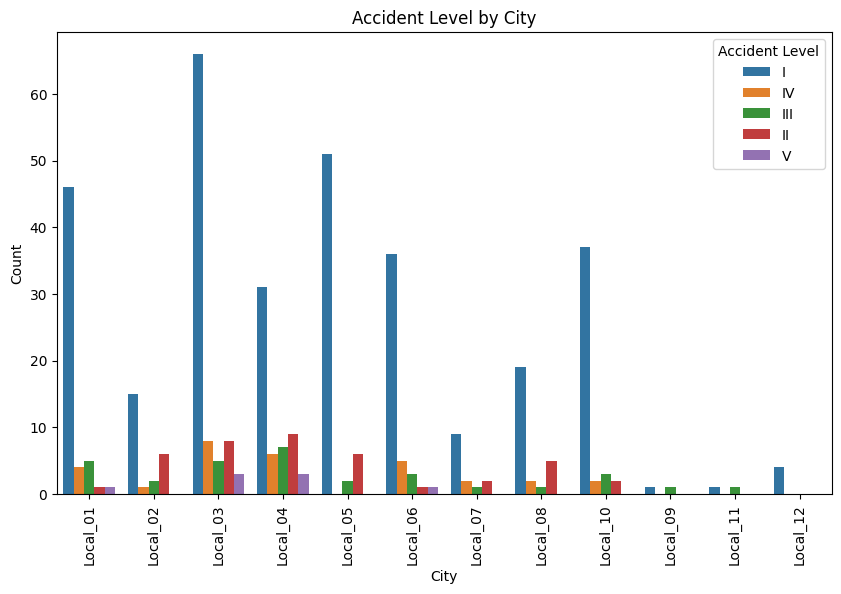

In [148]:
# prompt: Accident level by city

# Accident level by city
plt.figure(figsize=(10, 6))
sns.countplot(x='City', hue='Accident Level', data=data)
plt.title('Accident Level by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


### Data Preporcessing

In [154]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [155]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [156]:
# Function for text preprocessing
def clean_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

In [157]:
data['Cleaned_Description'] = data['Description'].apply(clean_text)

In [158]:
data[['Description', 'Cleaned_Description']].head()

,Description,Cleaned_Description
0,While removing the drill rod of the Jumbo 08 f...,removing drill rod jumbo 08 maintenance superv...
1,During the activation of a sodium sulphide pum...,activation sodium sulphide pump piping uncoupl...
2,In the sub-station MILPO located at level +170...,sub station milpo located level 170 collaborat...
3,Being 9:45 am. approximately in the Nv. 1880 C...,9 45 approximately nv 1880 cx 695 ob7 personne...
4,Approximately at 11:45 a.m. in circumstances t...,approximately 11 45 circumstance mechanic anth...
